In [ ]:
# Flickrからlandscapeとprotraitというタグを用いて画像を300枚づつ取得

import os
 
import time
import traceback
 
import flickrapi
from urllib.request import urlretrieve
 
import sys
from retry import retry
 
flickr_api_key = "API_KEY"
secret_key = "SECRET_KEY"
 
keywords = {"landscape", "portrait", "road"}

 
def get_photos(url, filepath):
    urlretrieve(url, filepath)
    time.sleep(1)
 
 
if __name__ == '__main__':
    flicker = flickrapi.FlickrAPI(flickr_api_key, secret_key, format='parsed-json')
    
    for keyword in keywords:
        response = flicker.photos.search(
            text=keyword,
            per_page=300,
            media='photos',
            sort='relevance',
            safe_search=1,
            extras='url_q,license'
        )
        photos = response['photos']

        try:
            if not os.path.exists('./image-data/' + keyword):
                os.mkdir('./image-data/' + keyword)

            number = 0;
            for photo in photos['photo']:
                url_q = photo['url_q']
                filepath = './image-data/' + keyword + '/' + str(number) + '.jpg'
                get_photos(url_q, filepath)
                number += 1
        
        except Exception as e:
            traceback.print_exc()

In [46]:
# landscape->0, portrait->1, load->2としてラベル付けを行う

import sys
import os 

outdir = "./image-data"

if not os.path.isdir(outdir):
    sys.exit('%s is not dir ' % outdir)

    # landscape->0, portrait->1, load->2
names = {
    "landscape": 0,
    "portrait": 1,
    "road": 2, 
}

exts = ['.JPG','.JPEG']

# ディレクトリ内のファイルを走査
with open("path_label.txt", "w") as file:
    for dirpath, dirnames, filenames in os.walk(outdir):
        for dirname in dirnames:
            if dirname in names:
                n = names[dirname]
                comp_dir = os.path.join(dirpath, dirname)
            
                for dirpath2, dirnames2, filenames2 in os.walk(comp_dir):
                    if not dirpath2.endswith(dirname):
                        continue
                    for filename2 in filenames2:
                        (fn,ext) = os.path.splitext(filename2)
                        #拡張子のチェック
                        if ext.upper() in exts:
                            img_path = os.path.join(dirpath2, filename2)
                            #書き出し　画像のパス ラベル(0-2)　という形式
                            file.write(img_path + " " + str(n) + "\n")

In [47]:
import sys
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.python,platform
import random

# 画像パスとラベルが書かれたテキストファイルを基にリストに追加
PATH_AND_LABEL = []
with open("./path_label.txt", mode='r') as file:
    for line in file:
        line = line.rstrip()
        
        line_list = line.split()
        PATH_AND_LABEL.append(line_list)
    random.shuffle(PATH_AND_LABEL)
    
DATA_SET = []

for path_label in PATH_AND_LABEL :

    tmp_list = []
    # リストのパスから画像を読み込み、サイズ変更
    img = cv2.imread(path_label[0])
    img = cv2.resize(img, (28, 28))

    # (28, 28, 3)のN次元配列を一次元に、dtypeをfloat32に、０〜１の値に正規化する
    img = img.flatten().astype(np.float32)/255.0
    tmp_list.append(img)

    # 分類するクラス数の長さを持つ仮のN次元配列を作成する
    classes_array = np.zeros(3, dtype = 'float64')
    # ラベルの数字によって、リストを更新する
    classes_array[int(path_label[1])] = 1

    tmp_list.append(classes_array)

    DATA_SET.append(tmp_list)
    

In [48]:
TRAIN_DATA_SIZE = int(len(DATA_SET) * 0.8)
TRAIN_DATA_SET = DATA_SET[:TRAIN_DATA_SIZE]
TEST_DATA_SET = DATA_SET[TRAIN_DATA_SIZE:]

In [49]:
# データセットをバッチサイズに分ける
def batch_data(data_set, batch_size) :

    data_set = random.sample(data_set, batch_size)

    return data_set

In [50]:
def devide_data_set(data_set) :
    # ndarrayにすることで、以下のように配列にアクセスすることができる。
    data_set = np.array(data_set)
    image_data_set = data_set[:int(len(data_set)), :1].flatten()
    label_data_set = data_set[:int(len(data_set)), 1:].flatten()

    image_ndarray = np.empty((0, 2352))
    label_ndarray = np.empty((0, 3))

    for (img, label) in zip(image_data_set, label_data_set) :
        image_ndarray = np.append(image_ndarray, np.reshape(img, (1, 2352)), axis=0)
        label_ndarray = np.append(label_ndarray, np.reshape(label, (1, 3)), axis=0)

    return image_ndarray, label_ndarray

In [80]:
CHANNELS = 3
NUM_CLASSES = 3
IMAGE_SIZE = 28
IMAGE_MATRIX_SIZE = IMAGE_SIZE * IMAGE_SIZE * CHANNELS
PATH_LABEL_FILE = "path_label.txt"

PATH_AND_LABEL = []

TRAIN_DATA_SIZE = int(len(DATA_SET) * 0.8)
TRAIN_DATA_SET = DATA_SET[:TRAIN_DATA_SIZE]
TEST_DATA_SET = DATA_SET[TRAIN_DATA_SIZE:]

# 畳み込みを行う
def conv2d(x, W) :
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# 最大プーリングを行う(プーリングサイズを2×2とする)
def max_pool_2x2(x) :
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 正規分布で標準偏差の2倍までのランダムな値で初期化
def weight_variable(shape) :
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape) :
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def deepnn(x) :

    with tf.name_scope('reshape') :
        x_image = tf.reshape(x, [-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
    
    # 畳み込み層1
    with tf.name_scope('conv1') :
        W_conv1 = weight_variable([5, 5, CHANNELS, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # プーリング層1
    with tf.name_scope('pool1') :
        h_pool1 = max_pool_2x2(h_conv1)

    # 畳み込み層2
    with tf.name_scope('conv2') :
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # プーリング層2
    with tf.name_scope('pool2') :
        h_pool2 = max_pool_2x2(h_conv2)
    
    # 全結合層1
    with tf.name_scope('fc1') :
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # ドロップアウト
    with tf.name_scope('dropout') :
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # 全結合層2
    with tf.name_scope('fc2') :
        W_fc2 = weight_variable([1024, NUM_CLASSES])
        b_fc2 = bias_variable([NUM_CLASSES])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return y_conv, keep_prob


def main(_):
    # 学習用入力データを一時的にいれておく
    x = tf.placeholder(tf.float32, [None, IMAGE_MATRIX_SIZE])

    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    y_conv, keep_prob = deepnn(x)
    
    # 損失関数(softmax関数)
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)
        
    # 訓練
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    # 平均を算出してaccuracyを出す
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    # グラフ描写用
    fig_train=[]
    fig_acc=[]
    fig_x=[]
    
    with tf.Session() as sess :
        sess.run(tf.global_variables_initializer())
        for epoch_step in range(MAX_EPOCH) :
            train_data_set = batch_data(TRAIN_DATA_SET, BATCH_SIZE)
            train_image, train_label = devide_data_set(train_data_set)
            
            # 訓練データでの精度
            train_accuracy = accuracy.eval(feed_dict={x: train_image, y_: train_label, keep_prob: 1.0})
            # テストデータでの精度
            test_image, test_label = devide_data_set(TEST_DATA_SET)
            test_accuracy = accuracy.eval(feed_dict={
                x: test_image, y_: test_label, keep_prob: 1.0})
            
            # グラフ描写用
            fig_train.append(train_accuracy)
            fig_acc.append(test_accuracy)
            fig_x.append(epoch_step)

            if epoch_step % BATCH_SIZE == 0 :     
                print('epoch_step %d: training accuracy %g, test accuracy %g' % 
                      (epoch_step, train_accuracy, test_accuracy))
            train_step.run(feed_dict={x: train_image, y_: train_label, keep_prob: 0.5})
    # グラフ描写
    plt.plot(fig_x, fig_train)
    plt.plot(fig_x, fig_acc)

# 最大の訓練回数
MAX_EPOCH = 1000
# 1回のバッチサイズ
BATCH_SIZE = 50


epoch_step 0: training accuracy 0.4, test accuracy 0.338889
epoch_step 50: training accuracy 0.58, test accuracy 0.583333
epoch_step 100: training accuracy 0.8, test accuracy 0.7
epoch_step 150: training accuracy 0.82, test accuracy 0.716667
epoch_step 200: training accuracy 0.82, test accuracy 0.711111
epoch_step 250: training accuracy 0.76, test accuracy 0.744444
epoch_step 300: training accuracy 0.96, test accuracy 0.744444
epoch_step 350: training accuracy 0.94, test accuracy 0.761111
epoch_step 400: training accuracy 0.96, test accuracy 0.766667
epoch_step 450: training accuracy 0.98, test accuracy 0.772222
epoch_step 500: training accuracy 0.98, test accuracy 0.75
epoch_step 550: training accuracy 1, test accuracy 0.805556
epoch_step 600: training accuracy 1, test accuracy 0.777778
epoch_step 650: training accuracy 0.98, test accuracy 0.8
epoch_step 700: training accuracy 0.98, test accuracy 0.788889
epoch_step 750: training accuracy 1, test accuracy 0.811111
epoch_step 800: trai

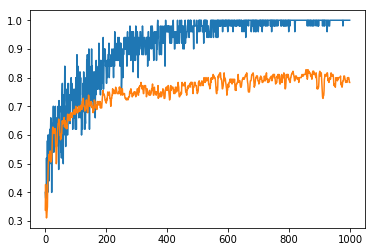

In [81]:
main(_)